### Random Walk
1. 문제: 19개의 node가 일렬로 있는데 가운데(10)에서 출발해서 random하게 움직이며 좌측 혹은 우측 끝에 도달하면 끝나는 문제이다. 
2. 조건: 
    - state: 말의 node 위치
    - action: 좌, 우 이동 
    - reward: 우측 끝에 도달(+1), 나머지 움직임(0)
    - terminal: 좌측, 우측 끝에 도달
    - start: 10번째 node 
    - policy: random policy
3. 학습 목표
    - $n$-step TD method

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
true_V = np.arange(-20, 22, 2) / 20.0
true_V[0] = true_V[-1] = 0

In [3]:
START = 10
LEFT = 0
RIGHT = 1

class RandomWalk:
    def __init__(self):
        self.state = START
        self.nA = 2
        self.nS = 21
        grid = np.arange(self.nS)
        P = defaultdict(lambda: [[] for i in range(self.nA)])

        for s in grid:
            if s == 19:
                P[s][LEFT] = [s - 1, 0, False]
                P[s][RIGHT] = [s + 1, 1, True]
            elif s == 1:
                P[s][LEFT] = [s - 1, -1, True]
                P[s][RIGHT] = [s + 1, 0, False]
            else:
                P[s][LEFT] = [s - 1, 0, False]
                P[s][RIGHT] = [s + 1, 0, False]
        self.P = P
        
    def step(self, action):
        next_state, reward, done = self.P[self.state][action]     
        self.state = next_state
        return [next_state, reward, done]
        
    def reset(self):
        self.state = START
        return self.state

In [4]:
def tabular_td_zero(env, num_episodes, policy, discount_factor, alpha):
    V = np.zeros(env.nS)
    rmse = []
    for i_episode in range(num_episodes):
        state = env.reset()
        while True:            
            action = policy()
            next_state, reward, done = env.step(action)
            V[state] += alpha * (reward + discount_factor * V[next_state] - V[state])
            if done:
                break
            state = next_state
        rmse.append(np.sqrt(np.sum(np.square(true_V - V))))
    return V, rmse

In [34]:
env = RandomWalk()
policy = lambda: np.random.binomial(1, 0.5)
V, rmse = tabular_td_zero(env, 100, policy, 1.0, 0.4)

In [35]:
V

array([ 0.        , -0.99934376, -0.98016861, -0.95861841, -0.91325817,
       -0.82835762, -0.68385944, -0.59417196, -0.51716319, -0.29505857,
       -0.00256325,  0.25460461,  0.4907967 ,  0.5590254 ,  0.68770196,
        0.77997196,  0.86072514,  0.89516325,  0.96124152,  0.98612553,  0.        ])

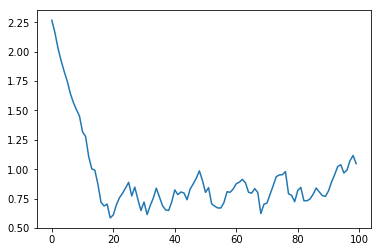

In [36]:
plt.plot(np.arange(100), rmse)
plt.show()

### n-step TD 
- 목적: state-value function $V(s)$를 구하기
- 알고리즘 설명:
    - $V(s)$를 초기화한다. 학습에 필요한 값(hyperparamter)들을 지정해준다.
    - 매 episode에 대해서 아래 내용을 반복한다.
        - 현재 state($s$)를 초기화한다. 
        - episode가 끝날 때까지 현재 state $s_t$를 통해 action($a$)을 구하고 action($a$)을 통해 MDP로부터 reward($R_t$), next_state($s_{t+1}$)를 얻는다. $s_t, R_t$는 매 생성 시 따로 저장해둔다. 
        - 현재 state $s_t$에 대해서 이 후 몇 $n$-step을 고려해서 improve 할 지 결정해줘야 한다. 예를 들면 $n=2$, $t=0$이라면 
        $t=1, t=2$의 reward, $V(S_2)$를 고려해서 $G = R_1 + \gamma R_2 + \gamma^2 V(S_2)$를 return이라고 근사한 뒤 이를 **TD target**으로 놓고 improve하는 식이다. 
        - episode를 생각했을 때 n개를 봤을 때 terminal에 도달하면 다음 episode로 넘어간다. 
        
가장 중요한 내용은 현재로부터 이후 몇 개의 step을 고려해서 Value function을 improve 하느냐이다.

![n-step TD](../images/n_step_TD.png) 
<center> 출처: Reinforcement Learning : An Introduction. Richard S. Sutton and Andrew G. Barto. 2017 (pp. 117) </center>

In [37]:
def n_step_td(env, num_episodes, policy, discount_factor, alpha, n):
    V = np.zeros(env.nS)
    rmse = []
    
    for i_episode in range(num_episodes):
        state = env.reset()
        rewards_sum = [0] # to store rewards
        states_sum = [state] # to store states
        T = np.inf # for non-episodic tasks 
        t = 0
        while True:
            if t < T:
                action = policy()
                next_state, reward, done = env.step(action)
                rewards_sum.append(reward)
                states_sum.append(state)
                if done:
                    T = t + 1
            # tau 
            tau = t - n + 1
            if tau >= 0:
                G = sum(pow(discount_factor, (i-tau-1)) * rewards_sum[i] for i in range(tau+1, min(tau+n+1, T+1)))
                if tau + n < T:
                    G += pow(discount_factor, n) * V[states_sum[tau+n]]
                V[states_sum[tau]] = V[states_sum[tau]] + alpha * (G - V[states_sum[tau]])                      
            if tau == T - 1:
                break                
            t += 1
            state = next_state            
        rmse.append(np.sqrt(np.sum(np.square(true_V - V))))
    return V, rmse

In [80]:
env = RandomWalk()
policy = lambda: np.random.binomial(1, 0.5)
V, rmse = n_step_td(env, 1000, policy, 0.95, 0.4, 4)

In [81]:
V

array([ 0.        , -0.50134038, -0.84186438, -0.73628615, -0.51973774,
       -0.35688033, -0.29425808, -0.16519313, -0.14383934, -0.111434  ,
        0.23513771,  0.32870762,  0.35932945,  0.45282568,  0.54874683,
        0.57143443,  0.7042172 ,  0.67133017,  0.91332849,  0.88013648,  0.        ])

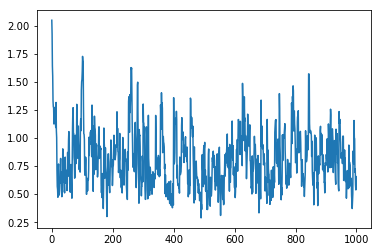

In [83]:
plt.plot(np.arange(1000), rmse)
plt.show()